# Running predictions on new ugis
24th May

Notebook for training ensemble of random forest models with MPNN hidden state vectors on new + old activity data and running prediction on generated isocyanide library.

Let's load the moonshot data first

In [1]:
import pandas as pd
import numpy as np
from dock2hit.fine_tuning import read_and_process_ugi_data

df_moonshot = read_and_process_ugi_data()

INFO:rdkit:Enabling RDKit 2021.09.4 jupyter extensions
INFO:root:No GPU found, using CPU
100%|██████████| 35/35 [00:00<00:00, 84.91it/s]
INFO:root:No GPU found, using CPU
100%|██████████| 15/15 [00:00<00:00, 74.52it/s]
INFO:root:No GPU found, using CPU
100%|██████████| 62/62 [03:43<00:00,  3.61s/it]
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_cpu/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_cpu/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_cpu/lib/pyth

Generate fingerprints

In [2]:
from dock2hit.generate_mpnn_fps import generate_mpnn_fps_from_dataframe

df_isocyanide = pd.read_csv('/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/enumerated_isocyanides.csv')
isocyanide_fps = generate_mpnn_fps_from_dataframe(df_isocyanide, smiles_col='ugi', batch_size=1024)
df_isocyanide['mpnn_fp'] = [fp for fp in isocyanide_fps]

Train RF

In [3]:
from dock2hit.fine_tuning.model_fitting import fit_forest


x = np.vstack(df_moonshot['mpnn_fp'].to_numpy())
y = np.vstack(df_moonshot['pIC50'].to_numpy())
random_forest_trained_on_all_data = fit_forest(x, y)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 567, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 4, 'bootstrap': False}


Predictions

In [4]:
df_isocyanide['predicted_pIC50'] = random_forest_trained_on_all_data.predict(isocyanide_fps)
df_isocyanide

,ID,SMILES,ugi,mpnn_fp,predicted_pIC50
0,EN300-07851,N#CSc1ccc(N)c(Br)c1,CC(C)Oc1ccc(N(C(=O)c2cocn2)C(C(=O)Nc2ccc(SC#N)...,"[-0.00017730345, -0.3309402, -0.078398645, -0....",5.071343
1,EN300-05713,COc1ccc(CCNC(=O)c2ccccc2N)cc1,COc1ccc(CCNC(=O)c2ccccc2NC(=O)C(c2cccnc2)N(C(=...,"[-0.00065635843, -0.30535138, -0.12650546, -0....",5.160705
2,EN300-16708,Nc1ncc(Br)cc1[N+](=O)[O-],CC(C)Oc1ccc(N(C(=O)c2cocn2)C(C(=O)Nc2ncc(Br)cc...,"[-0.00054333673, -0.32220128, -0.06790123, -0....",4.404305
3,EN300-20801,Nc1ccc(Br)cc1Cl,CC(C)Oc1ccc(N(C(=O)c2cocn2)C(C(=O)Nc2ccc(Br)cc...,"[-0.000163325, -0.27956185, -0.06165835, -0.02...",5.179794
4,EN300-02528,Nc1cccc(-c2nc3ccccc3s2)c1,CC(C)Oc1ccc(N(C(=O)c2cocn2)C(C(=O)Nc2cccc(-c3n...,"[-0.00025946388, -0.3584501, 0.009244882, -0.0...",4.521081
...,...,...,...,...,...
62806,EN300-37374326,COC(=O)c1cc(F)cc(N2CCNCC2)c1.Cl,COC(=O)c1cc(F)cc(N2CCN(C(=O)C(c3cccnc3)N(C(=O)...,"[-0.0012072898, -0.28709415, -0.08966437, -0.0...",4.225178
62807,EN300-6986645,CCNc1nncs1,CCN(C(=O)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(OC(C)...,"[-0.00013268134, -0.37337485, -0.043831952, -0...",4.645089
62808,EN300-7409229,CCC(CC)Nc1c([N+](=O)[O-])cc(C)c(C)c1[N+](=O)[O-],CCC(CC)N(C(=O)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(...,"[-0.0021201668, -0.25309363, -0.11261594, -0.0...",4.254808
62809,EN300-37374440,CNCCc1ccc(C(F)(F)F)cc1.Cl,CC(C)Oc1ccc(N(C(=O)c2cocn2)C(C(=O)N(C)CCc2ccc(...,"[-0.0007426523, -0.35482386, -0.17791161, -0.0...",4.774906


<AxesSubplot:>

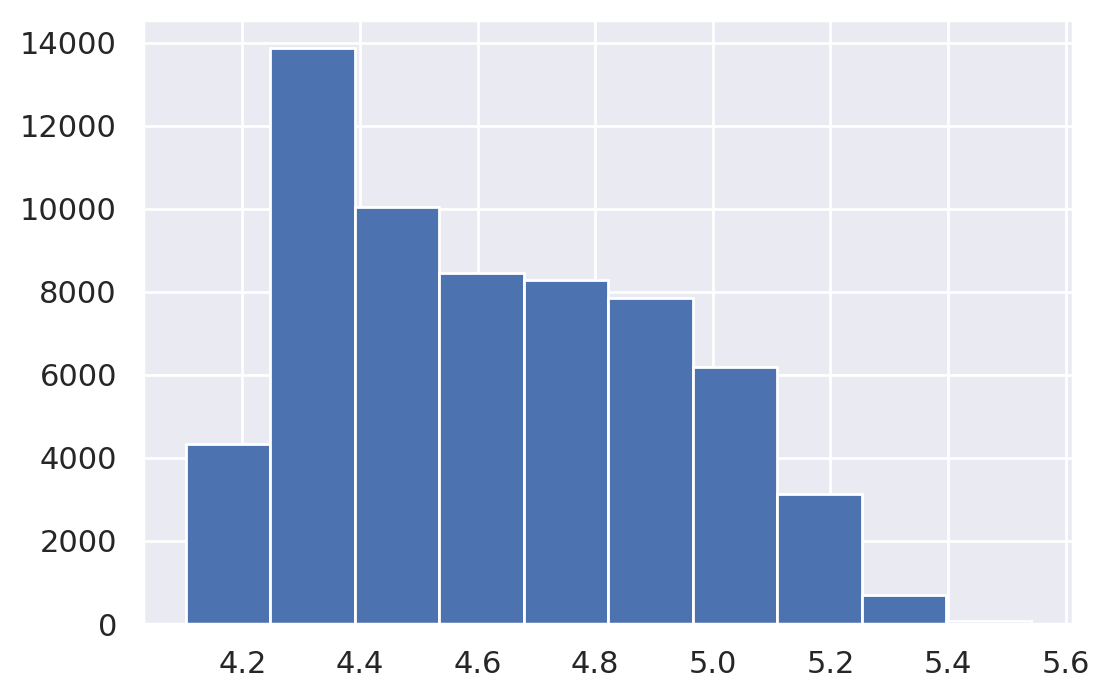

In [5]:
df_isocyanide['predicted_pIC50'].hist()


In [6]:
df_isocyanide.drop(columns='mpnn_fp').sort_values('predicted_pIC50', ascending=False).to_csv('/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/enumerated_isocyanides_scored.csv', index=False)

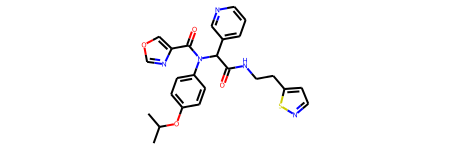

In [19]:
from rdkit.Chem import MolFromSmiles
best_ugi_smiles = 'CC(C)Oc1ccc(cc1)N(C(C(=O)NCCc1ccns1)c1cccnc1)C(=O)c1cocn1'
best_ugi_mol = MolFromSmiles(best_ugi_smiles)
best_ugi_mol

In [29]:
import mols2grid 
best_mols = df_isocyanide.drop_duplicates('ugi').nlargest(20, 'predicted_pIC50')
mols2grid.display(best_mols, 
                  smiles_col='ugi',
                  subset=['img', 'predicted_pIC50'],
                  transform={'predicted_pIC50': lambda x: f'Predicted pIC50: {x:.3f}'},
                  size=(300,300),
                  width=2000)
